# Section 4 - Computer vision-based machine learning #
## Mini-project 4: Building a 1D CNN for classification of waveforms ##

## Dr. Antonin Vacheret (avachere@imperial.ac.uk) 
## High Energy Physics Group
## 523 Blackett Lab

This projet is about designing a 1D Convolutional Neural Net (CNN) that classifies digitised signals from two type of scintillating materials used to record particle energy. 

There are many signal processing tasks where it is important to separate the signals recorded in different categories. Due the complex features of the signals recorded, a computer vision solution is well suited for solving this problem. 

We are dealing with two type of signals: 

* **The first type** of material is an organic scintillator (PVT) with **a fast time response** of a few nanoseconds. These fasts signals are also called Electron Scintillation (ES) signals.  

* **The second type** of material is an inorganic scintillator to detect neutrons (ZnS(Ag)), one of the oldest scintillator used. When a neutron is detected, the scintillation signal **a long trail of fast pulses that slowly decreases in amplitude**. These slow signals are called Nuclear Scintillation (NS) signals. 

We are interested here to separate as well as possible each type of signal and therefore coming up with a model that is able to have a very high score at predicting each class of signal.

Numpy files for the training and testing datasets (xtrain.npy, ytrain.npy) and their labels are already prepared. Each digitised waveform is a 1000 samples long with recorded pulses starting at a fixed time around 250 samples. Some examples of how to look at each signals and their label is provided below. Both type of signals have their amplitude normalised to the smallest pulse detectable i.e. what we call the 1 Photo-electron pulse. 

In [9]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from time import time
import copy
import pandas as pd 

In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# choose your preferred font size and style here for plots
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.serif'] = 'Times'

In [14]:
# importing the datasets
xtrain = np.load("x_train.npy")
ytrain = np.load("y_train.npy")
xtest = np.load("x_test.npy")
ytest = np.load("y_test.npy")
print(xtrain.shape,xtest.shape)
print(ytrain.shape,ytest.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/Downloads/Practical/Assessment/02158205 Qintong Li A4/Data4/x_train.npy'

In [8]:
train = torchvision.datasets.MNIST(root='./data', download=True, train=True)# transform=transforms.Compose([transforms.ToTensor()]))

RuntimeError: expand(torch.FloatTensor{[12302, 1000]}, size=[12302]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

tensor([[1, 2],
        [3, 4]])


In [27]:
train_loader = torch.utils.data.DataLoader(dataset=(xtrain,ytrain), shuffle=True, batch_size=10) #we can set the batch size for each interation
print(train_loader)

Below we are displaying a few examples from the training set to get a feel for the variability of the signal waveforms. 

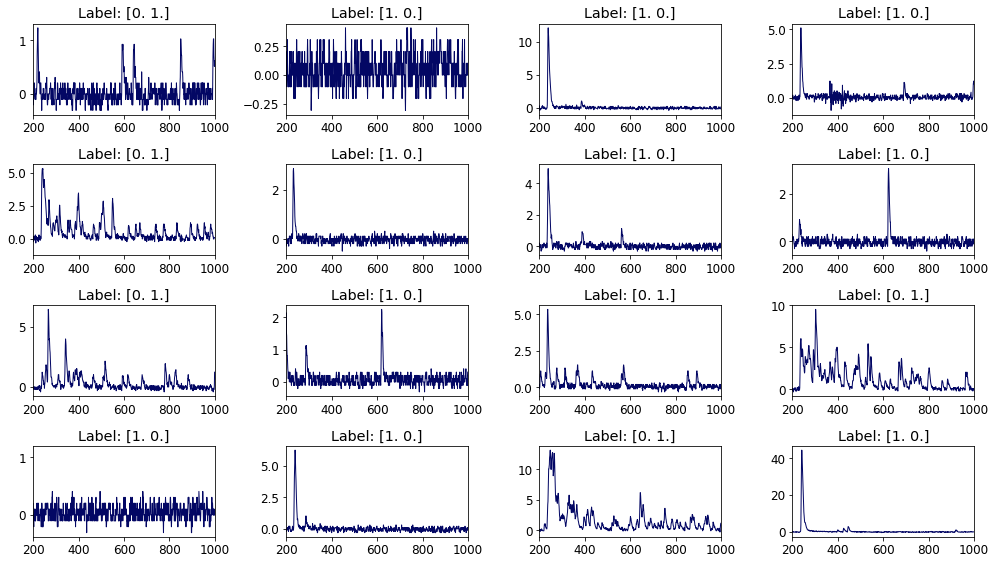

In [28]:
fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.flatten()
for i in range(0, 16):
    j = np.random.randint(0, len(xtrain))
    #print(j)
    ax[i].plot(xtrain[j],color='xkcd:darkblue',lw=1)
    ax[i].set_title("Label: {}".format(ytrain[j]))
    ax[i].set_xlim(200., 1000) #used to zoom around trigger time
fig.tight_layout()

The fast ES signals have labels ```[1,0]``` and the slower signals NS from neutrons have the other value ```[0,1]```. Notice that you can have some 1 PE pulses being present in the waveform for ES signals but generally not with the same density as NS signals.   

### Building the 1-dimensional CNN to classify the waveforms

* The relatively large differences between these two type of signals means the classification with simple pulse processing method yields an Area Under the curve (Integral of the ROC curve) of better than 95%. It is therefore expected that a well designed CNN provides an AUC > 95% with the aim to reach better than 99%.
* It is expected that datasets and dataloaders are implemented. Example of visualisation of plots showing features of the waveforms with some discussion is also expected. 
* The steps in designing and optimising the architecture should be clearly presented with a schematic of the final model architecture. It is important to explain why you have chosen some specific parameters or functions and don't hesitate the cite the literature if you have find the information in an article. 
* training/testing Loss and Accuracy and other parameters of the training should also be shown along with the final results. 
* Provide a plot with the output of the model for each class as well as the final ROC curve and AUC. 
* Feel free to add feature maps and other visualisation to support your discussion of performance and why

In [30]:
batch_size = 128
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x



In [32]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [33]:
model = Net().to(device)
#model.load_state_dict(torch.load('./data/mnist_cnns.pth'))
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [34]:
print(model)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)


(21840, [250, 10, 5000, 20, 16000, 50, 500, 10])

In [35]:
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

torch.save(model.state_dict(), './data/mnist_cnns.pth')

RuntimeError: stack expects each tensor to be equal size, but got [12302, 2] at entry 0 and [12302, 1000] at entry 1